## Problem 1

In [53]:
import numpy as np
from collections import defaultdict

Gradient descent implementation

In [553]:
def gradient_descent(oracle, x_0, x_min, tolerance=1e-10, max_iter=10000,
                     step_size_method = exact_line_search, trace=False):
    history = defaultdict(list) if trace else None
    message = 'ok'
    x_k = np.copy(x_0)
    i = 0
    grad = oracle.grad(x_0)
    if trace:
        history['func'].append(oracle.func(x_0) - f_min)
        history['grad_norm'].append(np.linalg.norm(grad))
        history['x'].append(x_k)
    while ((x_min - x_k)**2).sum() > tolerance and i < max_iter:
        alpha = step_size_method(oracle, x_k, (-1)*grad)
        x_k = x_k - alpha*grad
        grad = oracle.grad(x_k)
        i = i + 1
        if trace:
            history['func'].append(oracle.func(x_k)- f_min)
            history['grad_norm'].append(np.linalg.norm(grad))
            history['x'].append(x_k)
    if i == max_iter:
        message = 'iterations_exceeded'
    return x_k, message, history

Oracle for the quadratic function $f(x) = \frac1{2}x^TAx + b^Tx, x\in \mathbb{R}^2$

In [554]:
class QuadraticOracle(object):
    def __init__(self, A, b):
        if not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(self.A.dot(x), x) + self.b.dot(x)

    def grad(self, x):
        return self.A.dot(x) + self.b

    def hess(self, x):
        return self.A 

Armijo step-size

In [555]:
def armijo_line_search(oracle, x_k, d_k, c1 = 1e-3):
    alpha = 1.0
    while oracle.func(x_k + alpha*d_k) > oracle.func(x_k) + c1*alpha*oracle.grad(x_k).dot(d_k):
        alpha = alpha/2
    return alpha

Exact line search (derived in HW02)

$df = d\gamma\left<Ad, x + \gamma d\right> + d\gamma \left<A(x + \gamma d) ,d\right> + d\gamma\left<b,d\right>$

$df = 0 \Rightarrow \left<Ad, x + \gamma d\right> + \left<A(x + \gamma d) ,d\right> + \left<b,d\right> = x^TAd + \gamma d^TAd + d^TAx + \gamma d^TAd + b^Td = 2(x^TAd + \gamma d^TAd) + b^Td = 0$

$\Rightarrow \gamma = -\frac{\left<2Ax + b, d\right>}{2\left< Ad, d\right>}$

In out case $Q = \frac1{2}A, \nabla f(x) = Qx + b \Rightarrow \gamma = -\frac{\left<\nabla f(x), d\right>}{\left< Qd, d\right>}$

where  $d = -\nabla f(x) $

In [556]:
def exact_line_search(oracle, x_k, d_k):
    alpha = -oracle.grad(x_k).dot(d_k)/2/(oracle.A).dot(d_k).dot(d_k)
    return alpha

Golden rule step size

In [557]:
PHI = (1 + np.sqrt(5))/2
def golden_rule_search(oracle, x_k, d_k, tol=1e-3):
    alpha_max = 1.0
    alpha_min = 0.0
    c = x_k + (1 - 1/ PHI) * d_k
    d = x_k + d_k / PHI
    while ((c - d)**2).sum() > tol:
        if oracle.func(d) < oracle.func(c):
            alpha_min += (1 - 1/PHI)*(alpha_max - alpha_min)
        else:
            alpha_max = alpha_min + 1/PHI*(alpha_max - alpha_min)
        c = x_k + (alpha_min/PHI + alpha_max*(1 - 1/PHI)) * d_k 
        d = x_k + (alpha_min*(1 - 1/PHI) + alpha_max/PHI) * d_k
    return (alpha_max + alpha_min)/2

In [558]:
np.random.seed(1)

In [559]:
A = np.random.randn(2, 5)
A = A.dot(A.T)
b = np.random.randn(2)*3
oracle = QuadraticOracle(A, b)
x_min = -np.linalg.inv(A).dot(b)
f_min = oracle.func(x_min)
x_0 = np.random.randn(2)*3
print(A)

[[ 5.1919012  -4.96197148]
 [-4.96197148  9.08485594]]


In [560]:
import matplotlib.pyplot as plt

In [561]:
def f(X):
    return (A.dot(X.T)*X.T).sum(axis =0)/2 + b.dot(X.T)

def plot_results(history):
    x_k = np.array(history['x'])
    x_max = np.abs(x_k).max() + 0.5
    x = np.linspace(-x_max, x_max, 400)
    y = np.linspace(-x_max, x_max, 400)
    xx, yy = np.meshgrid(x, y)
    X = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis = 1)

    zz = f(X)
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].plot(np.log(history['func'])) 
    axes[0].set_title('log f(x) - f_min')
    axes[1].plot(np.log(np.linalg.norm(x_k - x_min, axis = 1)))
    axes[1].set_title('log norm(residual)')
    plt.contourf(xx, yy, zz.reshape(400, 400), cmap = plt.cm.Blues)
    plt.scatter(x_k[:, 0], x_k[:, 1], c = 'r')
    plt.plot(x_k[:, 0], x_k[:, 1], c = 'r')
    plt.scatter(x_min[0], x_min[1], c = 'g')
    #plt.colorbar()

Exact line search

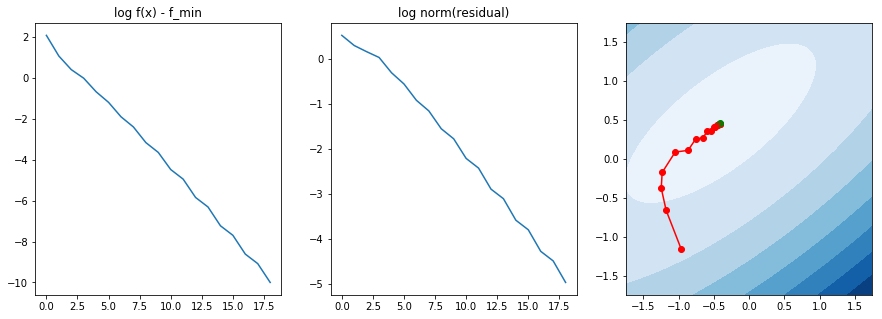

In [562]:
x_k, message, history = gradient_descent(oracle, x_0, x_min, tolerance=1e-4, max_iter=100,
                                         step_size_method = exact_line_search, trace=True)
plot_results(history)

Armijo rule

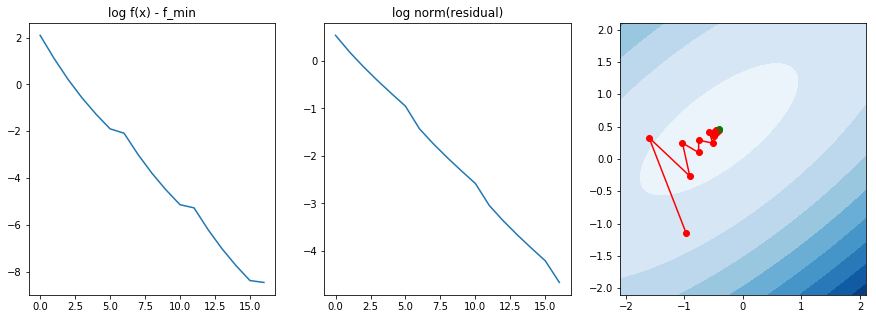

In [563]:
x_k, message, history = gradient_descent(oracle, x_0, x_min, tolerance=1e-4, max_iter=100,
                                         step_size_method = armijo_line_search, trace=True)
plot_results(history)

Golden rule

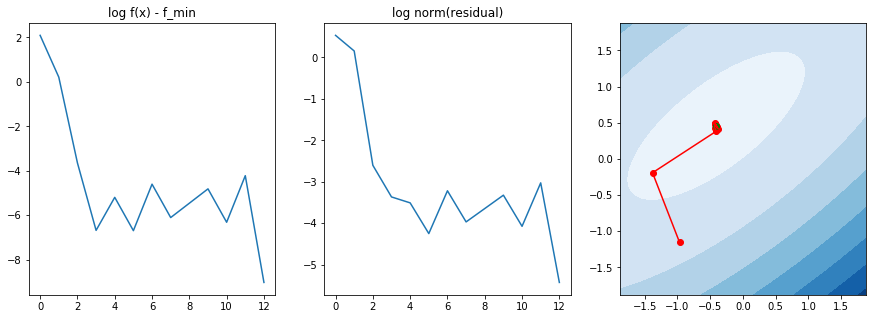

In [564]:
x_k, message, history = gradient_descent(oracle, x_0, x_min, tolerance=1e-4, max_iter=200,
                                         step_size_method = golden_rule_search, trace=True)
plot_results(history)

Coordinate descent

In [565]:
def coordinate_descent(oracle, x_0, x_min, tolerance=1e-5, max_iter=10000,
                       step_size_method = exact_line_search, trace=False):
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    i = 0
    E = np.eye(2)
    if trace:
        history['func'].append(oracle.func(x_0) - f_min)
        history['x'].append(x_k)
    while ((x_min - x_k)**2).sum() > tolerance and i < max_iter:
        alpha = step_size_method(oracle, x_k, E[i % 2])
        x_k = x_k + alpha*E[i % 2]
        i = i + 1
        if trace:
            history['func'].append(oracle.func(x_k) - f_min)
            history['x'].append(x_k)
    return x_k, history

Fibonacci search

In [566]:
def fibonacci_search(oracle, x_k, d_k, N = 7):
    Fn = [1, 1]
    alpha_max = 0.6
    alpha_min = -0.5
    for i in range(N - 1):
        Fn.append(Fn[-1] + Fn[-2])
    for i in range(1, N):
        delta = (alpha_max - alpha_min)/Fn[-i]
        a = x_k + (alpha_min + delta*Fn[- i - 2])*d_k
        b = x_k + (alpha_min + delta*Fn[- i - 1])*d_k
        if oracle.func(a) < oracle.func(b):
            alpha_max = alpha_min + delta*Fn[- i - 1]
        else:
            alpha_min = alpha_min + delta*Fn[- i - 2]
    return (alpha_min + alpha_max)/2

Exact line search

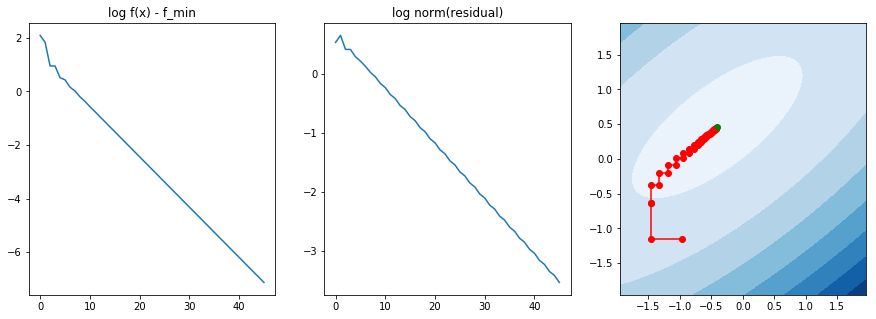

In [567]:
x_k, history = coordinate_descent(oracle, x_0, x_min, tolerance=1e-3, max_iter=100,
                                  step_size_method = exact_line_search, trace=True)
plot_results(history)

Fibonacci method

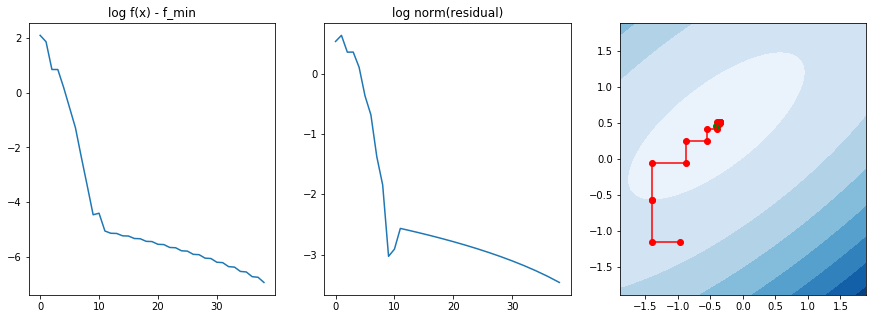

In [568]:
x_k, history = coordinate_descent(oracle, x_0, x_min, tolerance=1e-3, max_iter=100,
                                  step_size_method = fibonacci_search, trace=True)
plot_results(history)

## Problem 2

$x(t+1) = Ax(t) + bu(t)$  $(1)$

$F = \sum_{t=0}^{N -1}f(u(t))$

$F(a) = |a|, a \leq 1$

$F(a) = 2|a| - 1, a > 1$

$x(0) = 0, x(N) = x_{des}$

Applying $(1)$ N times we get: $x(N) = x_{des} = Ax(N-1) + bu(N -1) = A^Nx(0) + A^{N - 1}bu(0) + A^{N - 2}bu(1) +... + bu(N-1) = $

$=A^{N - 1}bu(0) + A^{N - 2}bu(1) +... + bu(N-1)$

We can define matrix $C = [A^{N - 1}b, A^{N - 2}b, ... b]$

And vector $\tilde{u} = [u(0), u(1), ... u(N-1)]$, then we have a constraint $Cu = x_{des}$

If we add a variable $t$: $t \geq |a|, \ t \geq 2|a| - 1$, we get the exact $t_{min} = F(a)$ 

The inequalities are equivalent to $-t\leq a\leq t$, $-\frac{t+1}{2}\leq a\leq\frac{t+1}{2}$

Then we can have vector $\tilde{t}$, $\tilde{t}_i: a = u_i$

Then a LP formulation of the problem is:

minimize $\mathbb{1}^T\tilde{t}$

subject to: $Cu = x_{des}$

$-t\leq u\leq t$

$-\frac{t+1}{2}\leq u\leq\frac{t+1}{2}$

In [431]:
import cvxpy as cvx

In [546]:
A = np.array([[-1, 0.4, 0.8],[1, 0, 0],[0, 1, 0]])
b = np.array([1, 0, 0.3])
x_des = [7, 2, -6]
x_0 = np.zeros(3)

In [547]:
N = 30
C = np.zeros((3, 30))
C[:, -1] = b
for i in range(2, 31):
    C[:, -i] = A.dot(C[:, - i +1])

In [548]:
u = cvx.Variable(N)
t = cvx.Variable(N)

constraints = [C*u == x_des,
               u >= -t,
               t >= u,
               u >= -(t + 1)/2,
               (t + 1)/2 >= u]

p = cvx.Problem(cvx.Minimize(np.ones(N)*t), constraints)
p.solve()

17.323567853890694

In [481]:
X = np.zeros((3, N + 1))
U = np.array(u.value)[:, 0]
x = x_0
for i in range(N):
    X[:, i+1] = A.dot(X[:, i]) + U[i]*b

Text(0.5, 0, 't')

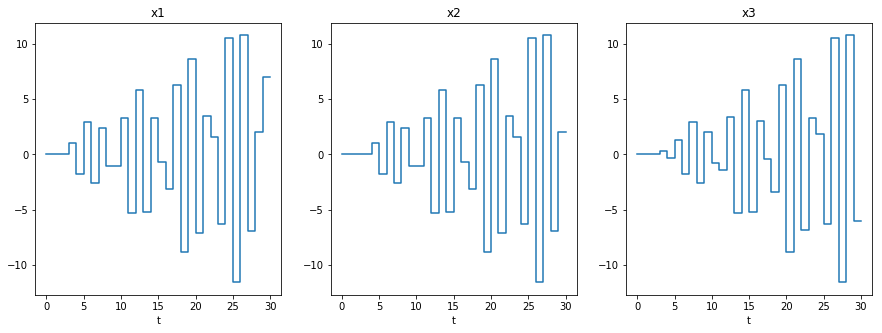

In [491]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].step(np.arange(31),X[0, :])
axes[0].set_title('x1')
axes[0].set_xlabel('t')
axes[1].step(np.arange(31),X[1, :])
axes[1].set_title('x2')
axes[1].set_xlabel('t')
axes[2].step(np.arange(31),X[2, :])
axes[2].set_title('x3')
axes[2].set_xlabel('t')

Text(0.5, 0, 't')

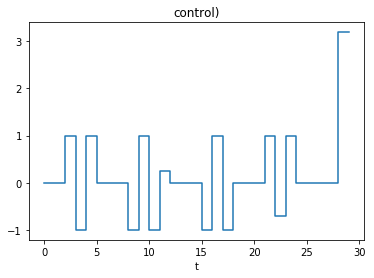

In [569]:
plt.step(np.arange(30), U)
plt.title('control)')
plt.xlabel('t')

To validate sensitivity to every component lets perturb $x_{des}$ 100 times at each component and look at the variance of the obtained control values.

In [525]:
Us_1 = []
for i in range(100):
    x_des_ = np.array([7, 2, -6]) 
    x_des_[0] += np.random.randn()
    u = cvx.Variable(N)
    t = cvx.Variable(N)

    constraints = [C*u == x_des_,
                   u >= -t,
                   t >= u,
                   u >= -(t + 1)/2,
                   (t + 1)/2 >= u]

    p = cvx.Problem(cvx.Minimize(np.ones(N)*t), constraints)
    p.solve()
    U_ = np.array(u.value)[:, 0]
    Us_1.append(U_)

0.05837874915517178


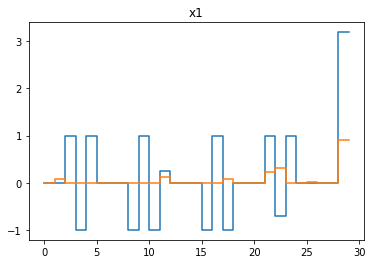

In [529]:
Us_1 = np.array(Us_1)
plt.step(np.arange(30), U, label = 'u0')
plt.step(np.arange(30), Us_1.std(axis = 0), label = 'std of u')
plt.title('x1')
print(Us_1.std(axis = 0).mean())

0.1144061098666252


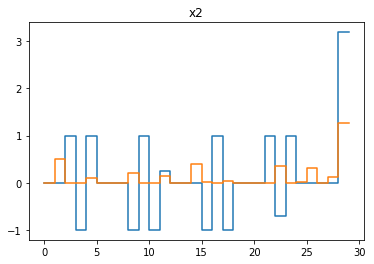

In [530]:
Us_2 = []
for i in range(100):
    x_des_ = np.array([7, 2, -6]) 
    x_des_[1] += np.random.randn()
    u = cvx.Variable(N)
    t = cvx.Variable(N)

    constraints = [C*u == x_des_,
                   u >= -t,
                   t >= u,
                   u >= -(t + 1)/2,
                   (t + 1)/2 >= u]

    p = cvx.Problem(cvx.Minimize(np.ones(N)*t), constraints)
    p.solve()
    U_ = np.array(u.value)[:, 0]
    Us_2.append(U_)

Us_2 = np.array(Us_2)
plt.step(np.arange(30), U, label = 'u0')
plt.step(np.arange(30), Us_2.std(axis = 0), label = 'std of u')
plt.title('x2')
print(Us_2.std(axis = 0).mean())

0.11157607584492671


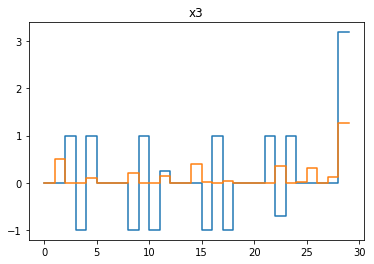

In [531]:
Us_3 = []
for i in range(100):
    x_des_ = np.array([7, 2, -6]) 
    x_des_[2] += np.random.randn()
    u = cvx.Variable(N)
    t = cvx.Variable(N)

    constraints = [C*u == x_des_,
                   u >= -t,
                   t >= u,
                   u >= -(t + 1)/2,
                   (t + 1)/2 >= u]

    p = cvx.Problem(cvx.Minimize(np.ones(N)*t), constraints)
    p.solve()
    U_ = np.array(u.value)[:, 0]
    Us_3.append(U_)

Us_3 = np.array(Us_3)
plt.step(np.arange(30), U, label = 'u0')
plt.step(np.arange(30), Us_2.std(axis = 0), label = 'std of u')
plt.title('x3')
print(Us_3.std(axis = 0).mean())

The system is more sensitive to the $x_2$ and $x_3$ than to $x_1$